refer to Kaggle [Code sharing, 13th place, no external data](https://www.kaggle.com/c/rossmann-store-sales/discussion/17979)

[code address](http://nbviewer.jupyter.org/github/JohanManders/ROSSMANN-KAGGLE/blob/master/ROSSMANN%20STORE%20SALES%20COMPETITION%20KAGGLE.ipynb)

#### 1. Trick data cleaning: remove outlier values(?how to find them) We can try to remove more outlier values and let the system find the outlier values more automatically

#### Other tricks:

- We can try to modify the PromoInterval0 of each store to Yes/No for every day
- train one model for one store
- Try to use the last batch of data as the valid data

#### ideas for final result
- Use the knn method
- Use the median value
- Use the basic 3 layer nn method
- Use the deep learning method 
- train on the model the kernel but not my own computer

In [67]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

import datetime
import collections

%matplotlib inline

from sklearn.cross_validation import train_test_split

# pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
# pd.set_option('display.width',100)
# pd.set_option('expand_frame_repr',False)
# pd.set_option('precision',6)


In [102]:
import keras

Using TensorFlow backend.


In [103]:
keras.__version__

'2.0.0'

## Setting seed

In [2]:
seed=42

# Reading Sales data

In [3]:
df_train=pd.read_csv('data/train.csv',parse_dates=['Date'])
df_submit=pd.read_csv('data/test.csv',parse_dates=['Date'])

/Users/pengjuzhao/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
### Setting a variable to distinguish train(1) from submit 0
df_train['Set']=1
df_submit['Set']=0

#### Trick: concat train & test data together to do data preprocessing

In [5]:
### Combine train and test set
frames=[df_train,df_submit]
df=pd.concat(frames)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058286 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [7]:
features_x=['Store','Date','DayOfWeek','Open','Promo','SchoolHoliday','StateHoliday']
features_y=['SalesLog']

#### Trick-data cleaning: remove open store but no sales

In [8]:
df=df.loc[~((df['Open']==1)&(df['Sales']==0))]
df.loc[df['Set']==1,'SalesLog']=np.log1p(df.loc[df['Set']==1,'Sales'])

In [9]:
# Quick way to handle the category data
df['StateHoliday']=(df['StateHoliday'].astype('category').cat.codes)

### Trick: quick date handling 

In [10]:
var_name = 'Date'
df[var_name+'Day']=df.Date.dt.day
df[var_name+'Month']=df.Date.dt.month
df[var_name+'Year']=df.Date.dt.year
df[var_name+'Week']=df.Date.dt.week
df[var_name+'DayOfYear']=df.Date.dt.dayofyear

df[var_name+'Day']=df[var_name+'Day'].fillna(0)
df[var_name+'Month']=df[var_name+'Month'].fillna(0)
df[var_name+'Year']=df[var_name+'Year'].fillna(0)
df[var_name+'Day']=df[var_name+'Day'].fillna(0)
df[var_name+'Week']=df[var_name+'DayOfYear'].fillna(0)

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [11]:
df['DateInt']=df['Date'].astype(np.int64)

# Reading store data


In [12]:
df_store=pd.read_csv('data/store.csv')
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
### Convert store type and assortmen to numerical categories
df_store['StoreType']=df_store.StoreType.astype('category').cat.codes
df_store['Assortment']=df_store.Assortment.astype('category').cat.codes

In [14]:
### convert competition open year and month to float
def convertCompetitionOpen(df):
    try:
        date='{}-{}'.format(int(df['CompetitionOpenSinceYear']),int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

df_store['CompetitionOpenInt']=df_store.apply(lambda df:convertCompetitionOpen(df),axis=1 )




In [15]:
# Convert competition open year and week 
def convertPromo2(df):
    try:
        date='{}{}1'.format(int(df['Promo2SinceYear']),int(df['Promo2SinceWeek']) )
        return pd.to_datetime(date,format='%Y%W%w')
    except:
        return np.nan

df_store['Promo2SinceFloat']=df_store.apply(lambda df:convertPromo2(df),axis=1).astype(np.int64)

In [16]:
### Convert competition open year and month to float
def convertPromo2(df):
    try:
        date_ =pd.to_datetime('{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek'])), format='%Y%W%w')
        return date_.date()
    except:
        return np.nan

df_store['Promo2SinceFloat'] = df_store.apply(lambda df: convertPromo2(df), axis=1)

In [17]:
s=df_store['PromoInterval'].str.split(',').apply(pd.Series,1)
s.columns=['PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3']
df_store=df_store.join(s)

In [18]:
def monthToNum(date):
    return {
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12}[date]

df_store['PromoInterval0']=df_store['PromoInterval0'].map(lambda x:monthToNum(x) if str(x)!='nan' else np.nan)
df_store['PromoInterval1']=df_store['PromoInterval1'].map(lambda x:monthToNum(x) if str(x)!='nan' else np.nan)
df_store['PromoInterval2']=df_store['PromoInterval2'].map(lambda x:monthToNum(x) if str(x)!='nan' else np.nan)
df_store['PromoInterval3']=df_store['PromoInterval3'].map(lambda x:monthToNum(x) if str(x)!='nan' else np.nan)

In [19]:
del df_store['PromoInterval']

In [20]:
store_features=['Store','StoreType','Assortment','CompetitionDistance','CompetitionOpenInt','PromoInterval0']
# PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3 correlated with each other

features_x=list(set(features_x+store_features))

In [21]:
df=df.merge(df_store[store_features],on=['Store'])

In [22]:
### convert every Nan to -1
for feature in features_x:
    df[feature]=df[feature].fillna(-1)

### Manually Check and Correct some Strange Data in Stores

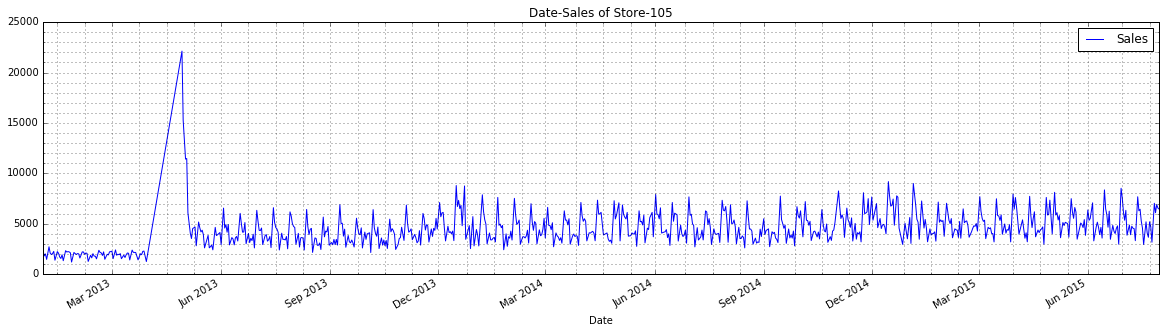

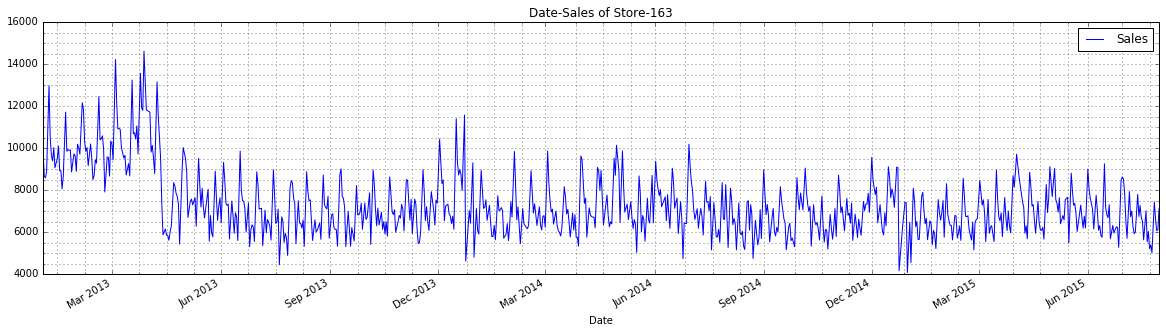

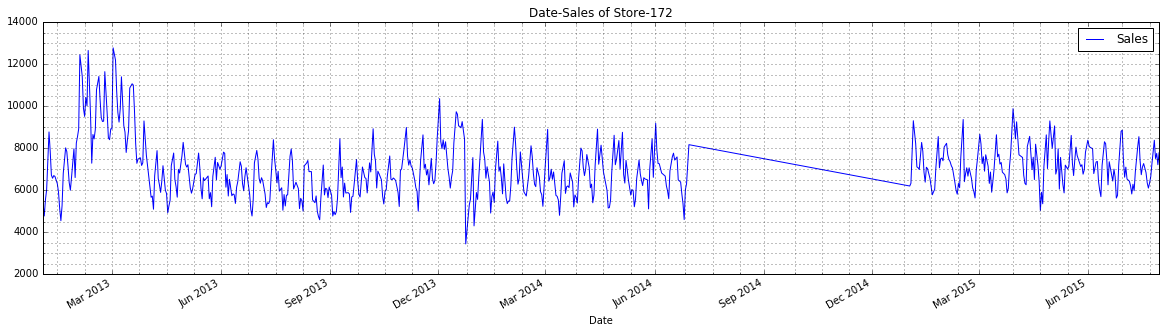

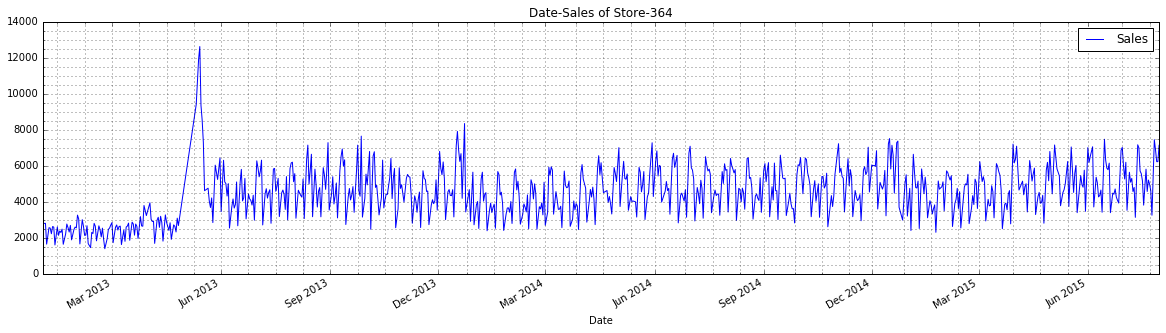

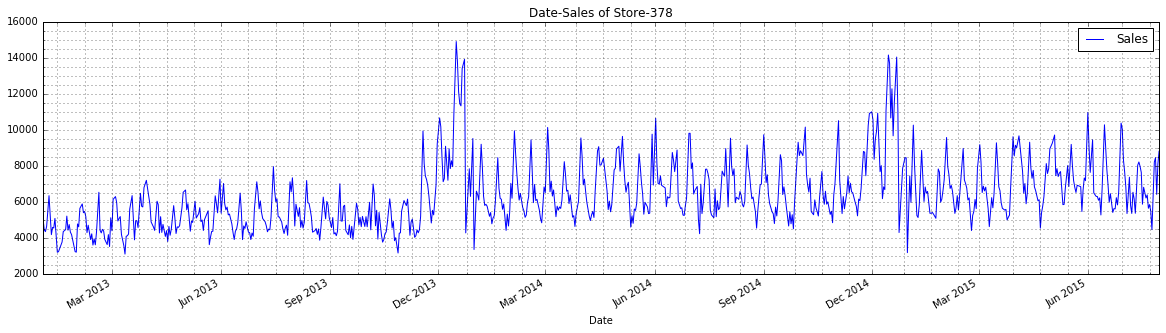

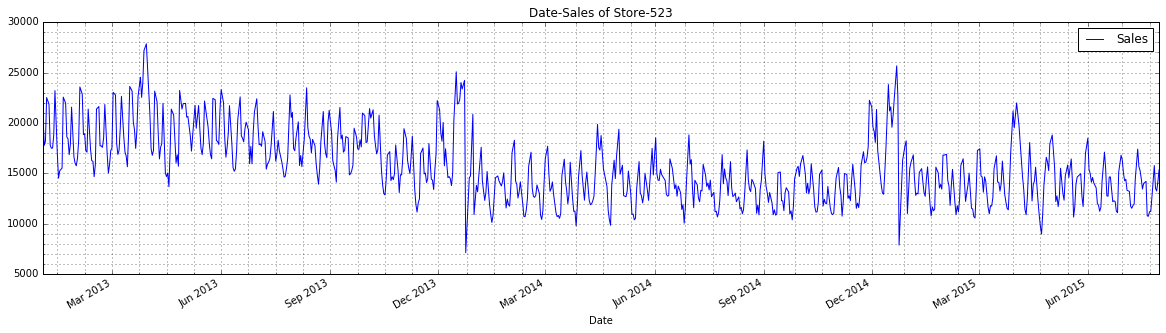

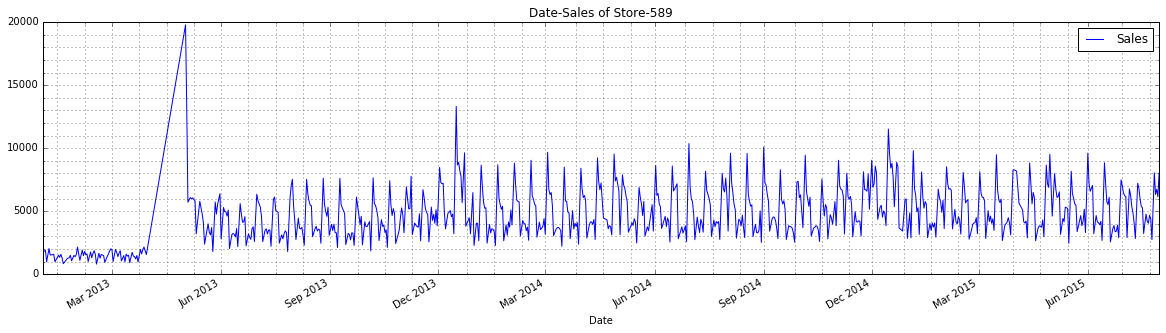

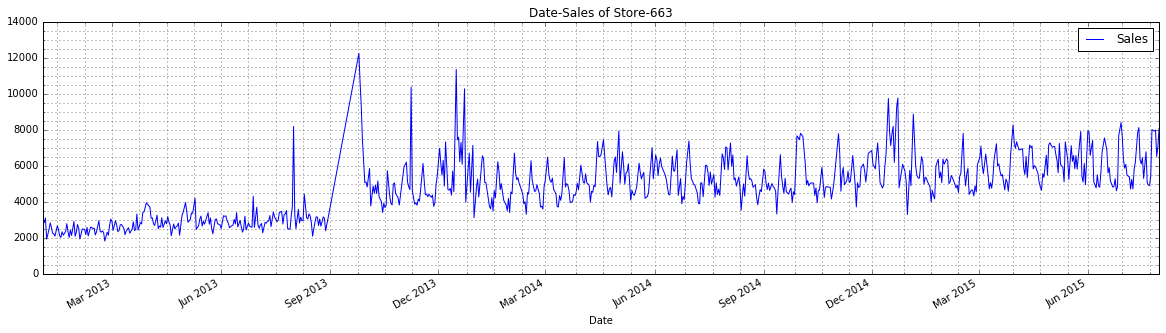

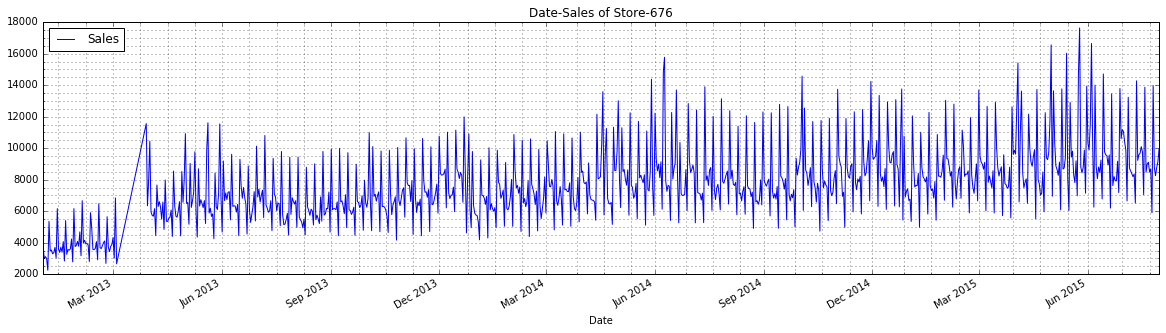

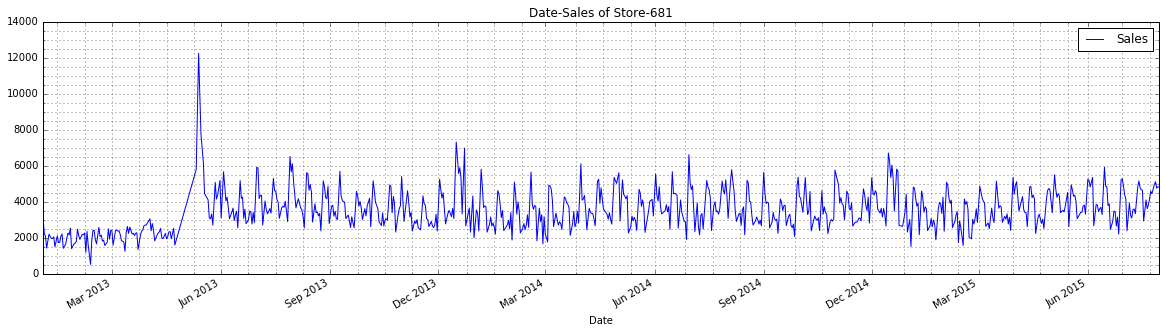

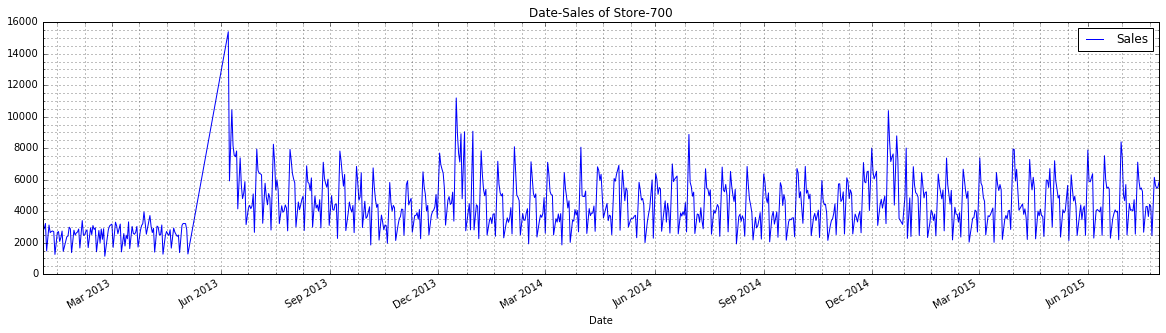

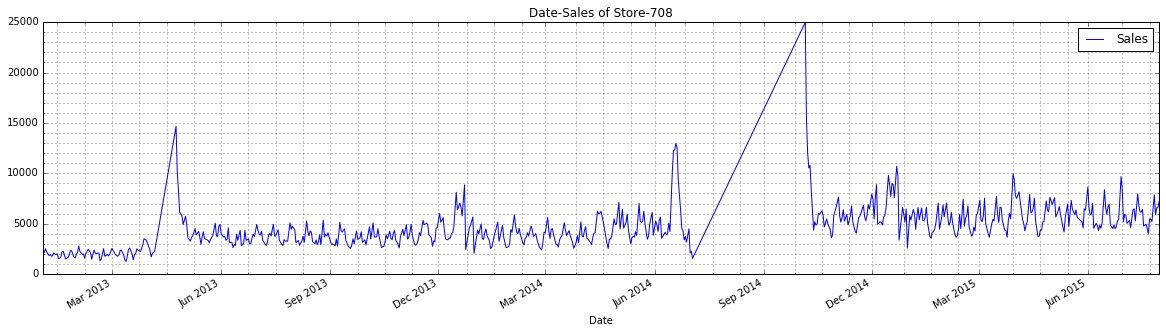

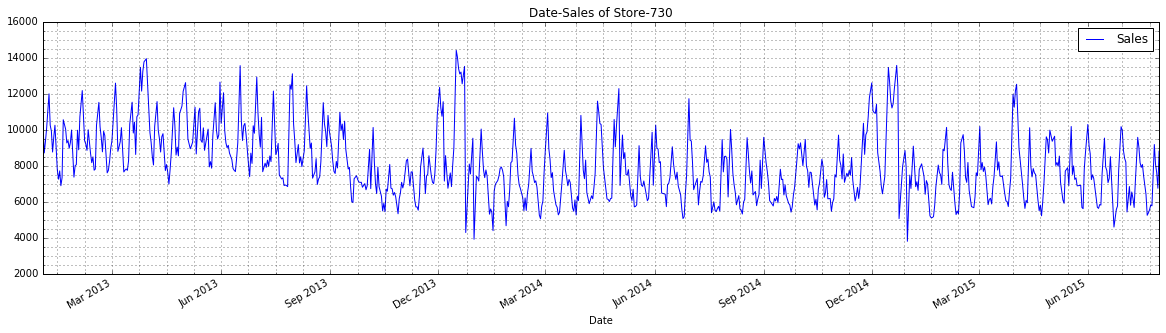

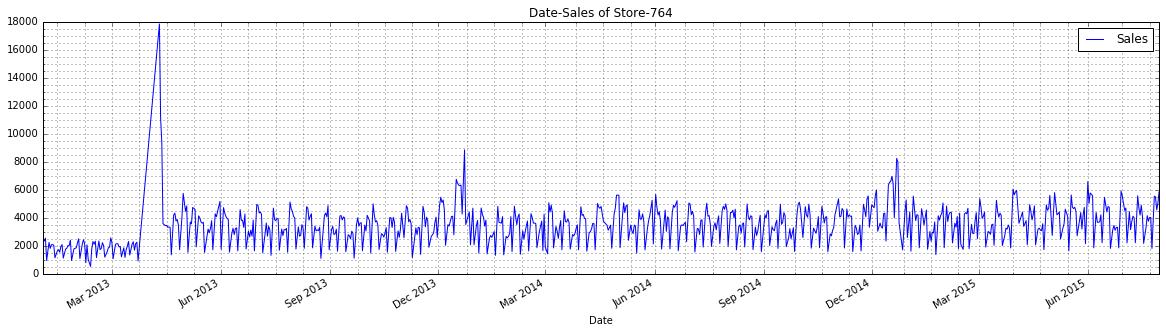

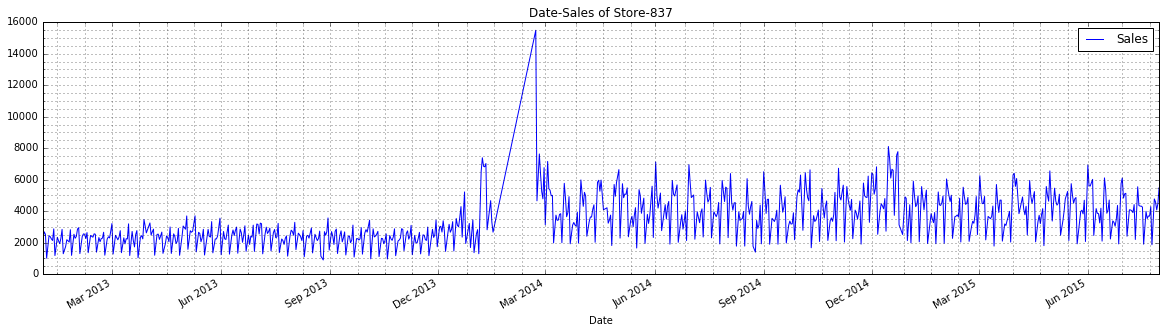

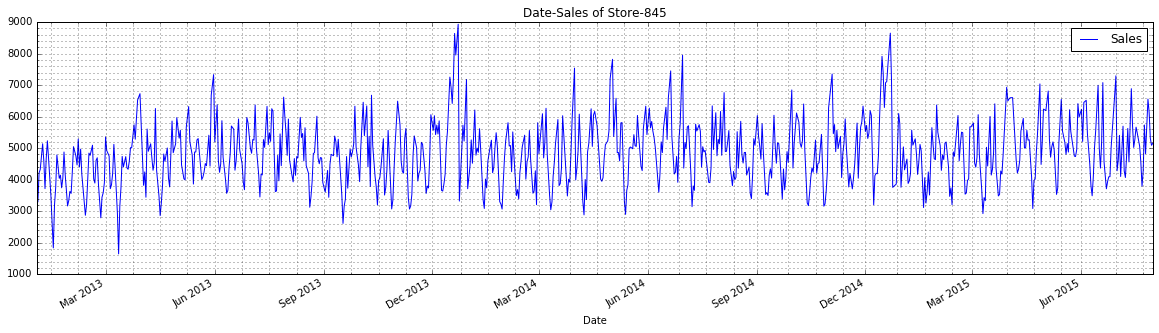

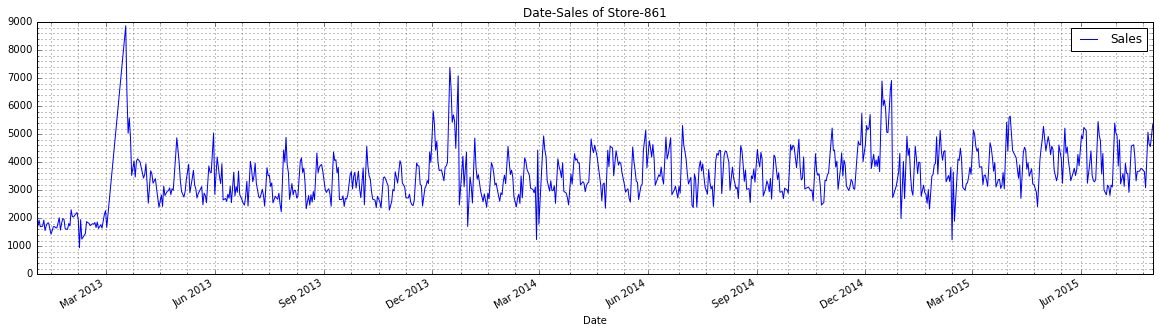

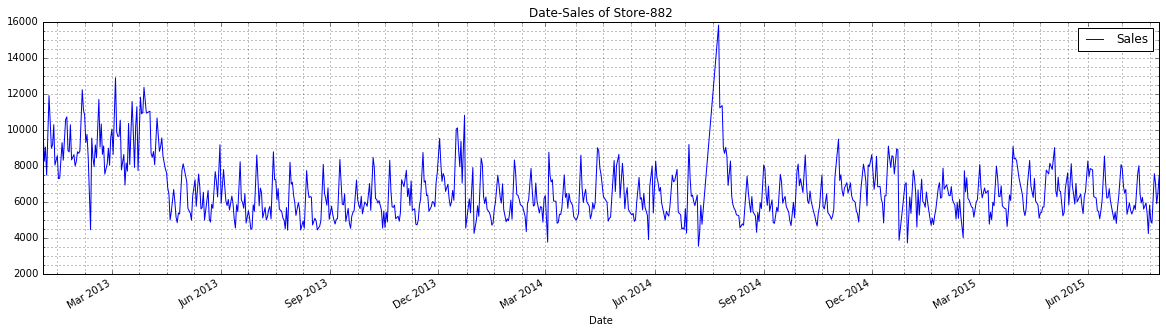

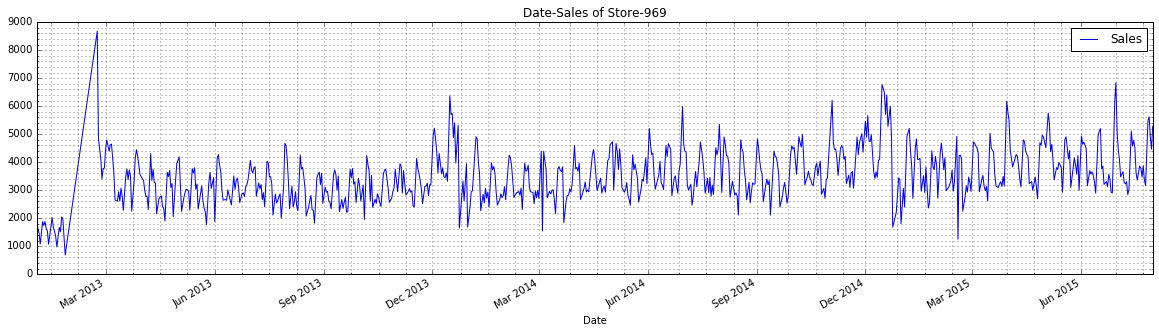

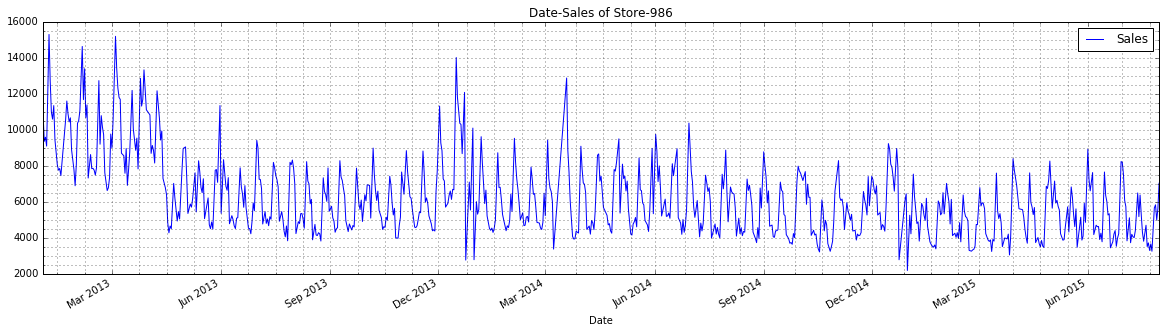

In [23]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

j=1
for i in list_stores_to_check:
    stor=i
    #Normal sales    
    store_sales=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1),['Date','Sales']])
    store_sales.set_index('Date',inplace=True)
    store_sales.plot(figsize=(20,5),title='Date-Sales of Store-{}'.format(stor))
    plt.grid(True,which='both')
    plt.minorticks_on()
    j+=1
    plt.show()

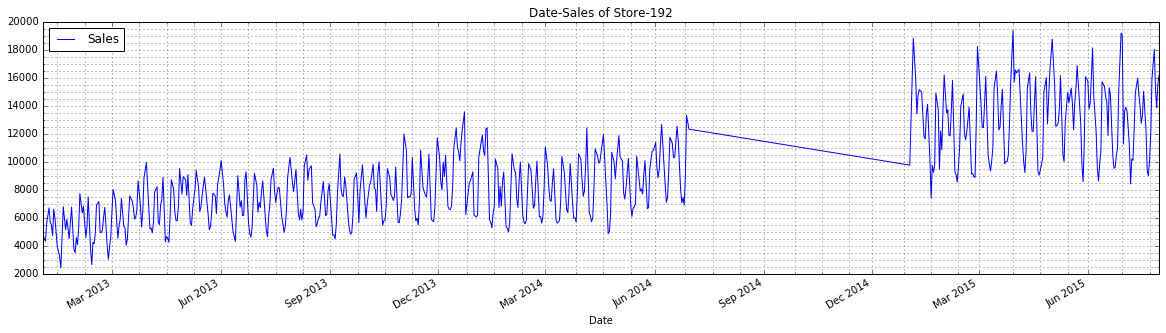

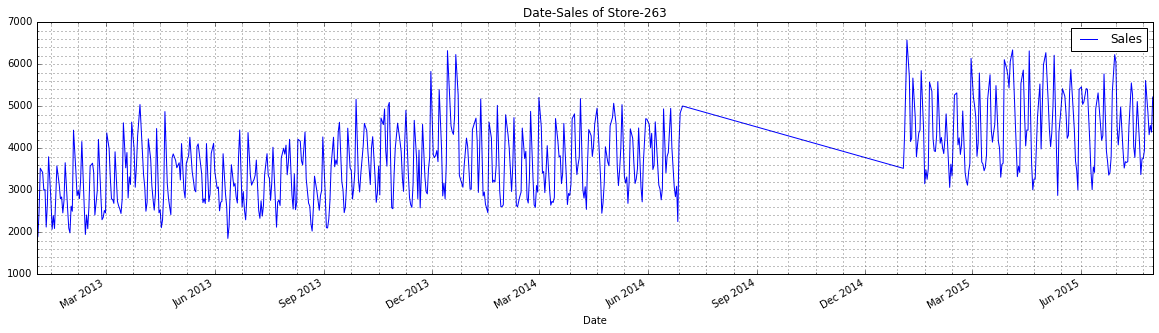

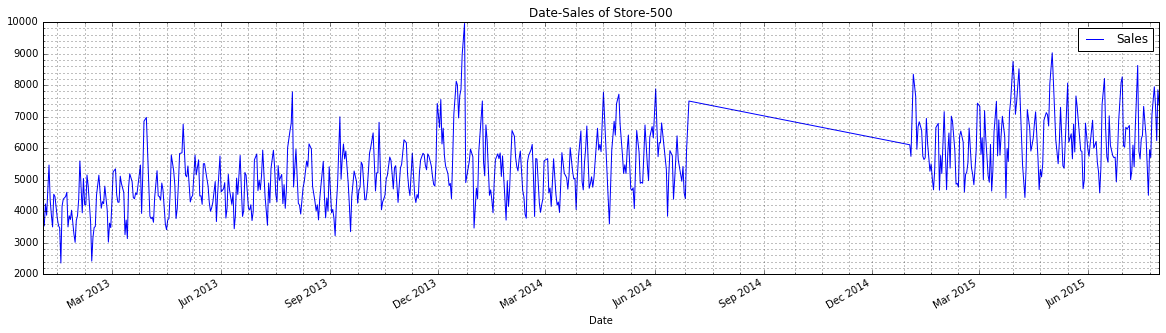

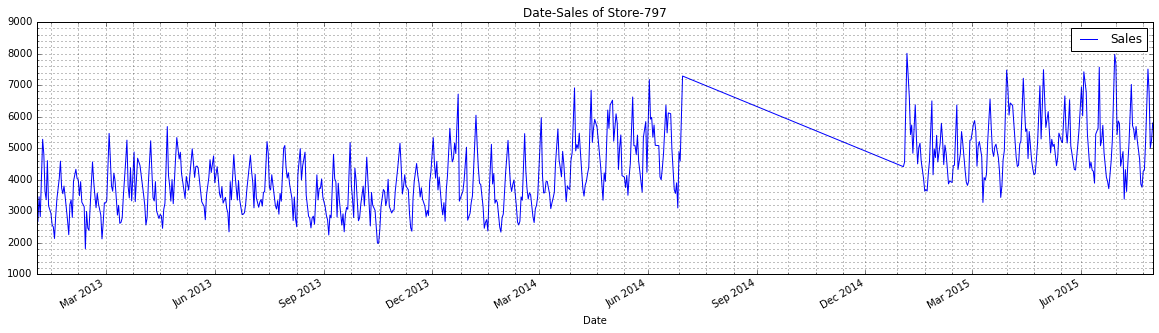

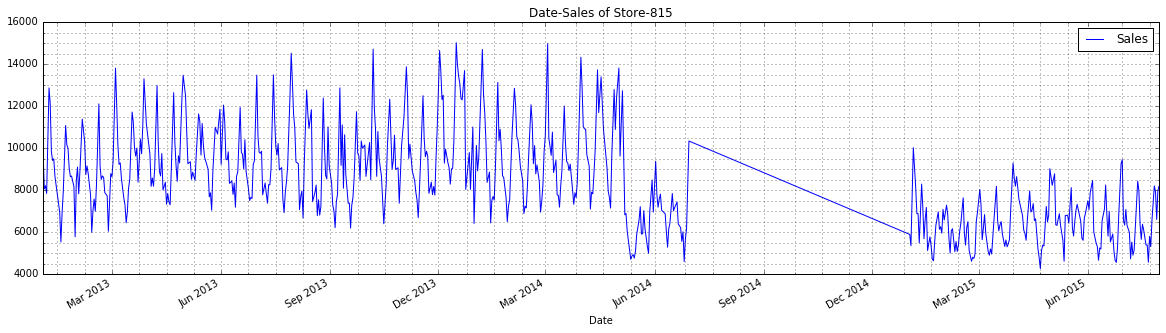

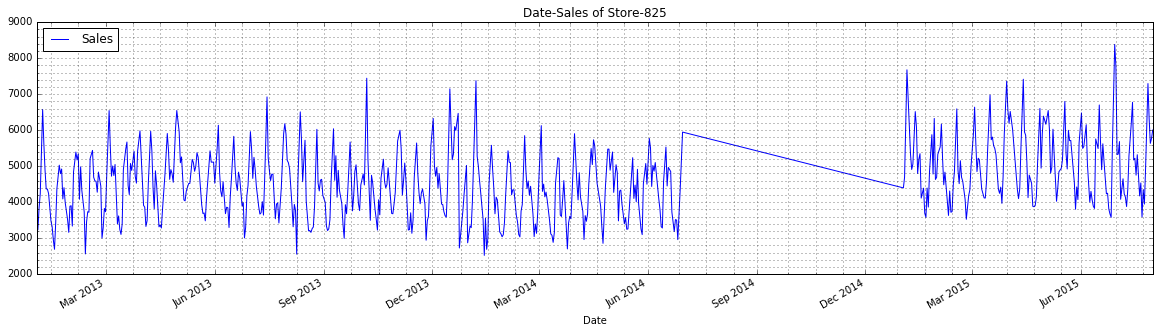

In [24]:
list_stores_to_check = [192,263,500,797,815,825]

j=1
for i in list_stores_to_check:
    stor=i
    
    #Normal sales    
    
    store_sales=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1),['Date','Sales']])
    store_sales.set_index('Date',inplace=True)
    store_sales.plot(figsize=(20,5),title='Date-Sales of Store-{}'.format(stor))
    plt.grid(True,which='both')
    plt.minorticks_on()
    j+=1
    plt.show()


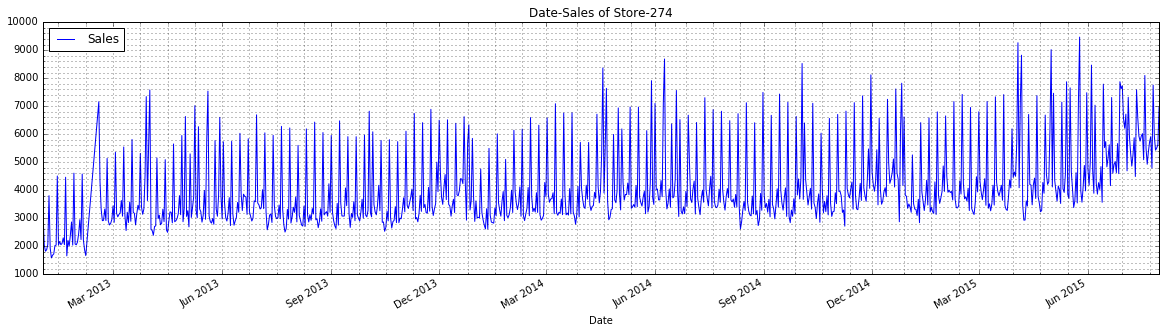

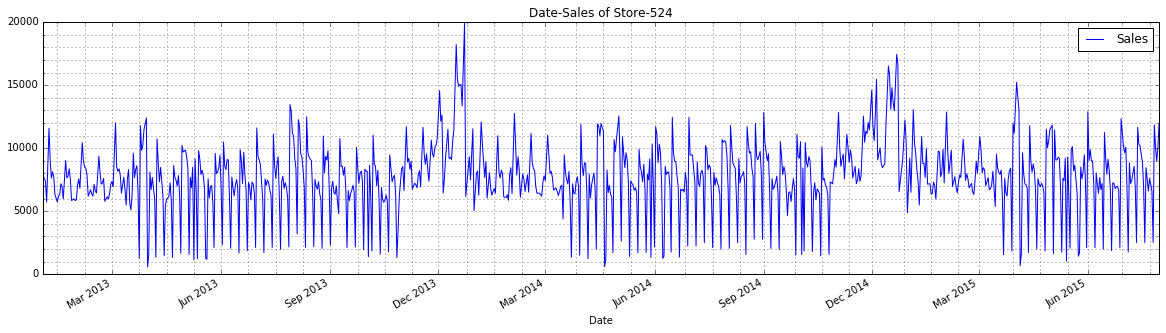

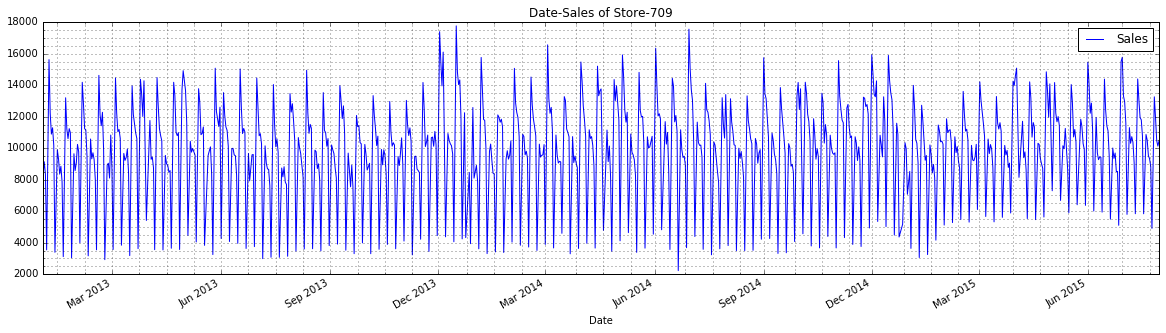

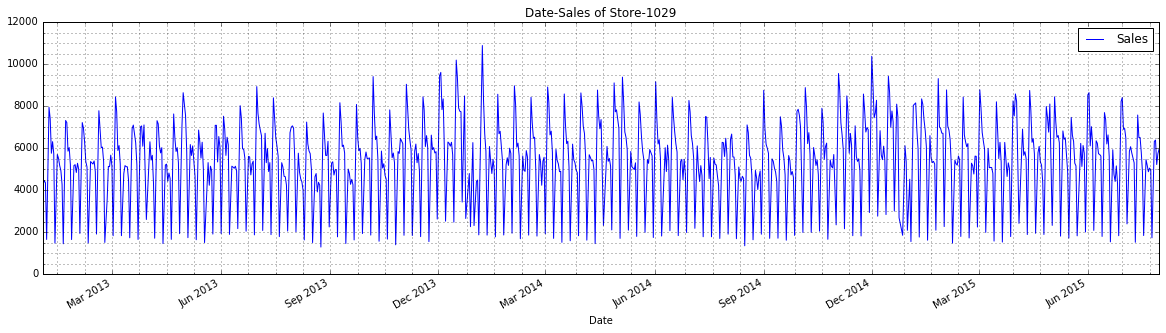

In [25]:
list_stores_to_check = [274,524,709,1029]

j=1
for i in list_stores_to_check:
    stor=i
    
    #Normal sales    
    
    store_sales=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1),['Date','Sales']])
    store_sales.set_index('Date',inplace=True)
    store_sales.plot(figsize=(20,5),title='Date-Sales of Store-{}'.format(stor))
    plt.grid(True,which='both')
    plt.minorticks_on()
    j+=1
    plt.show()


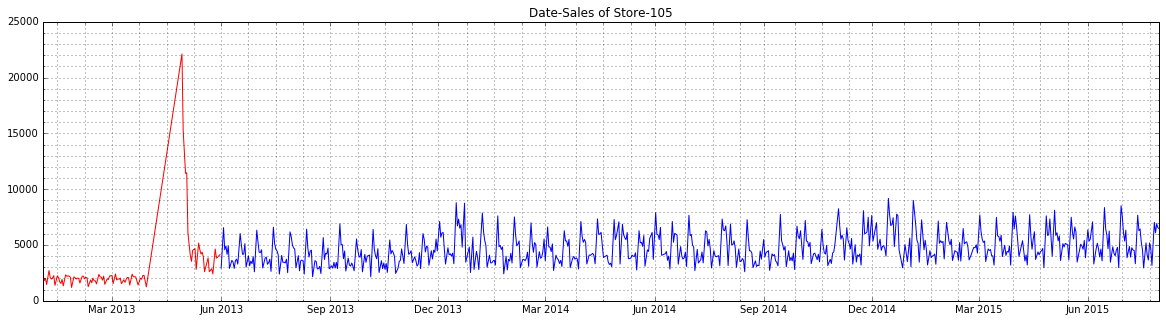

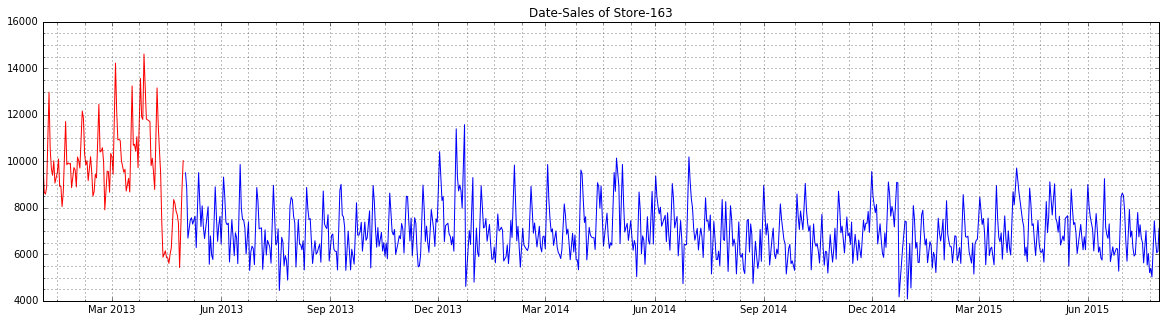

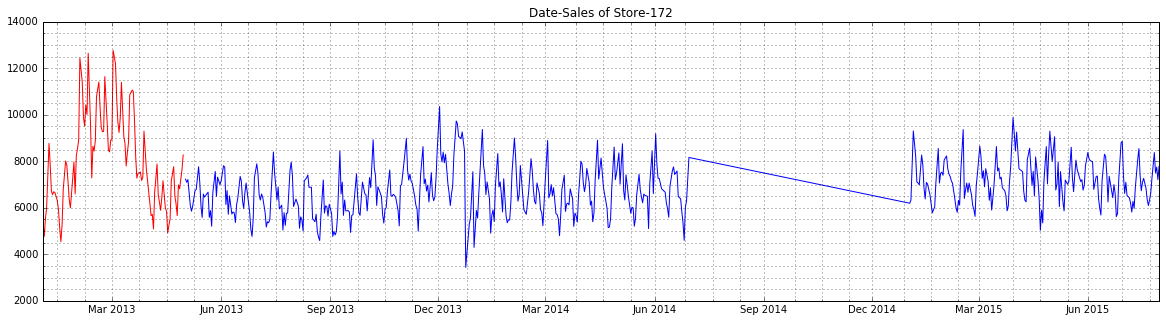

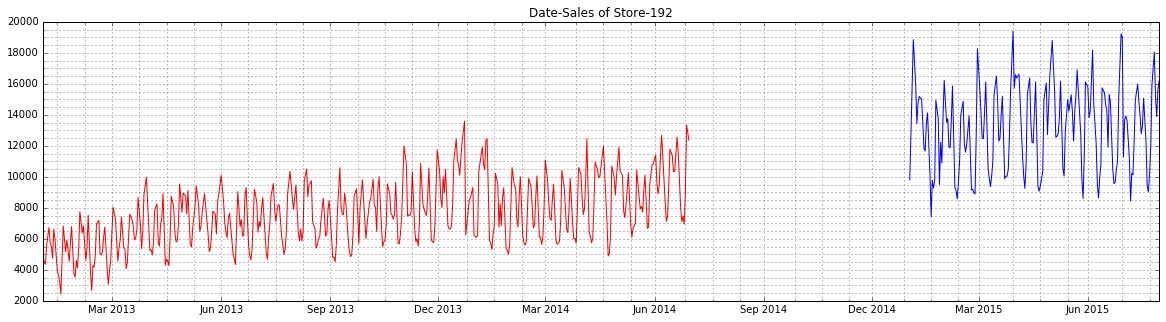

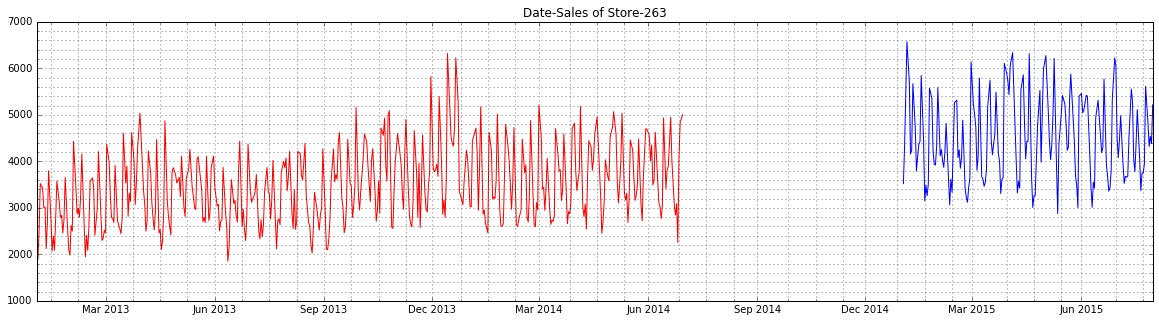

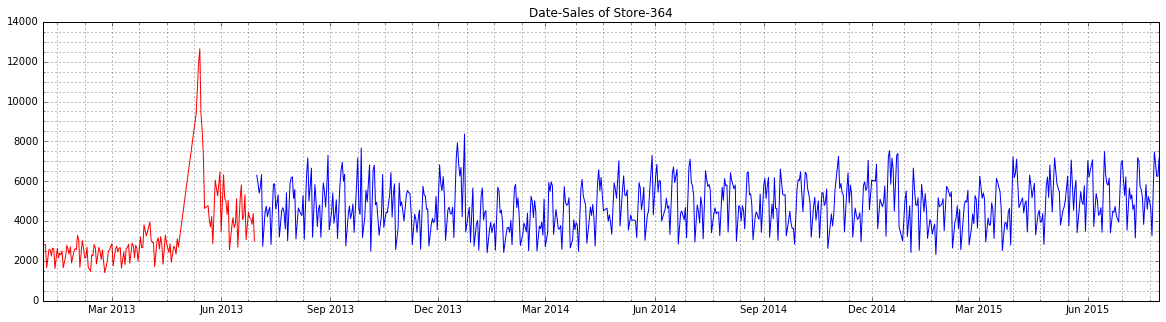

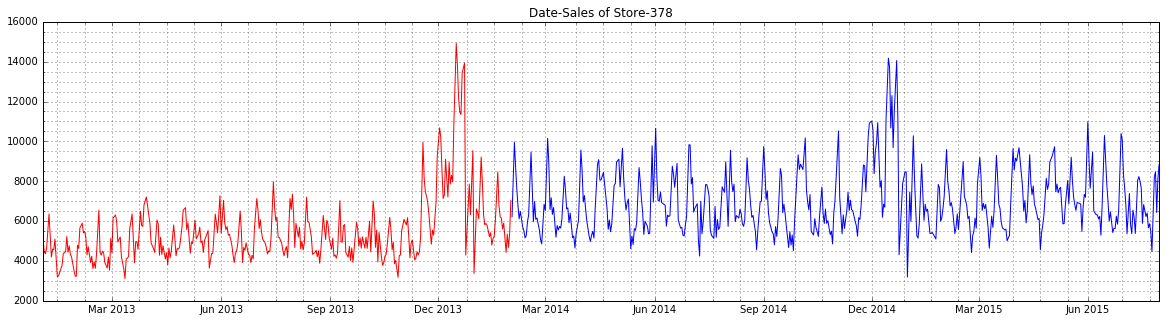

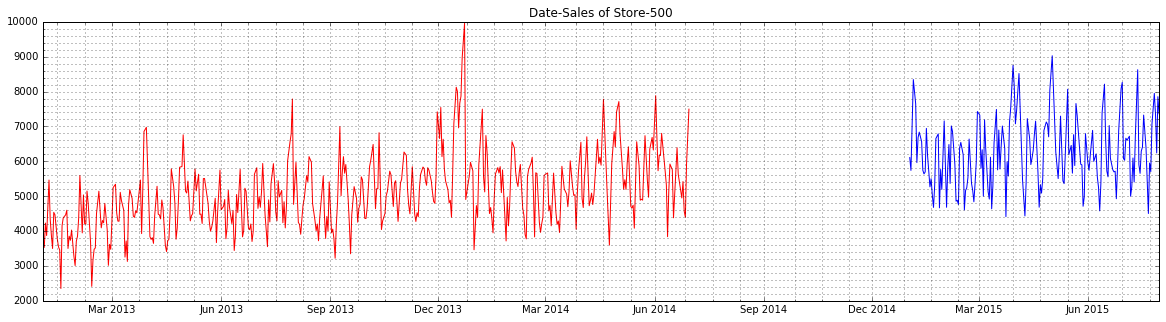

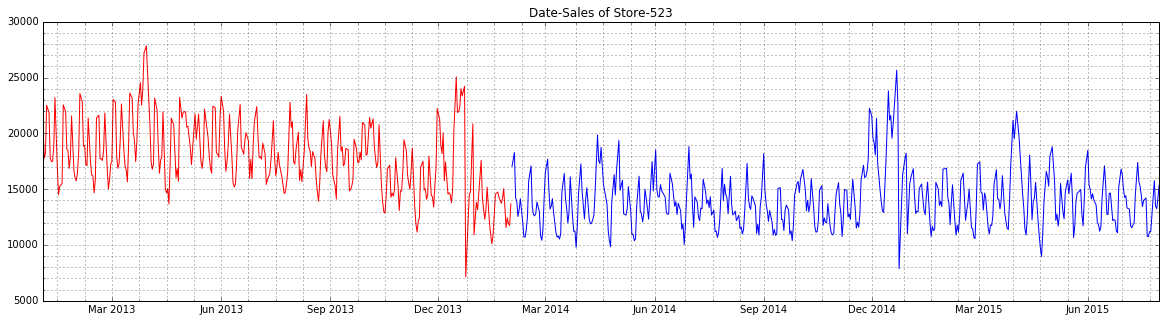

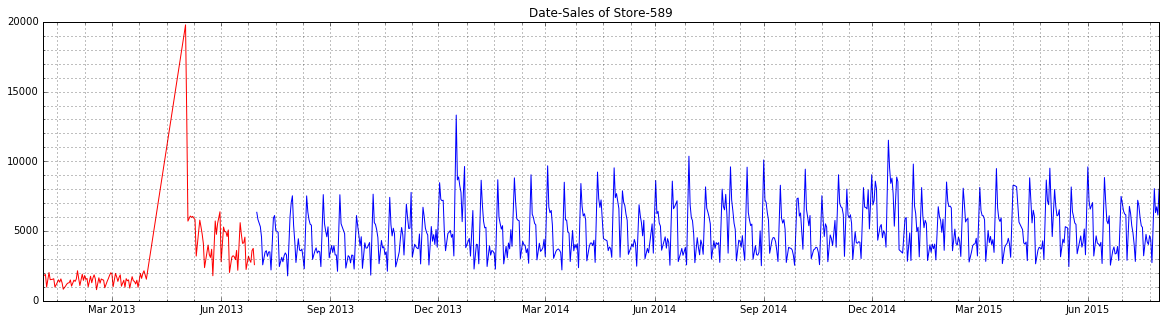

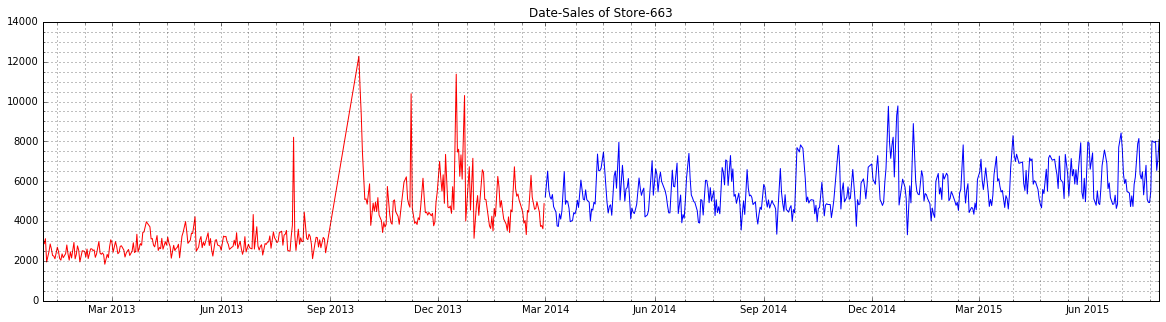

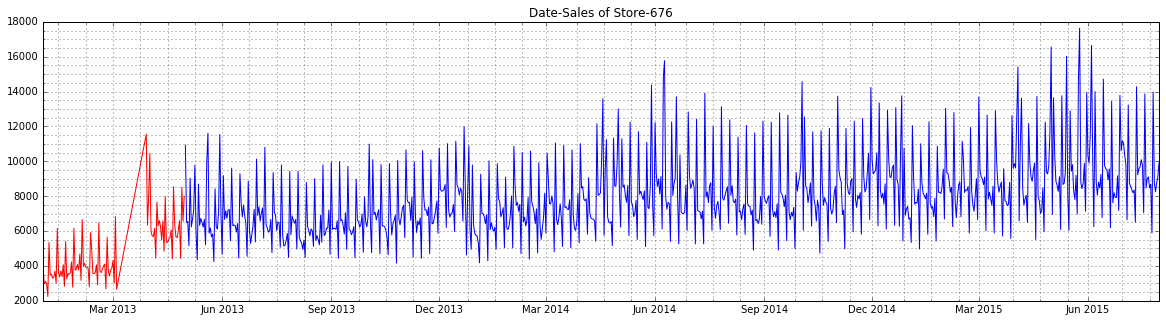

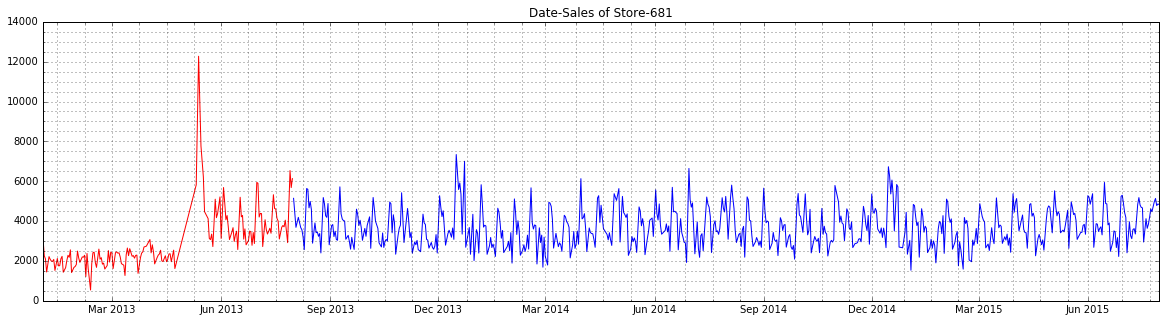

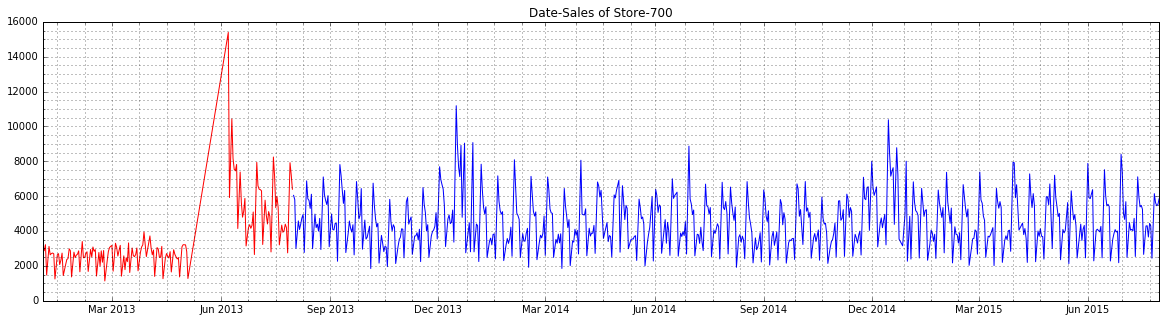

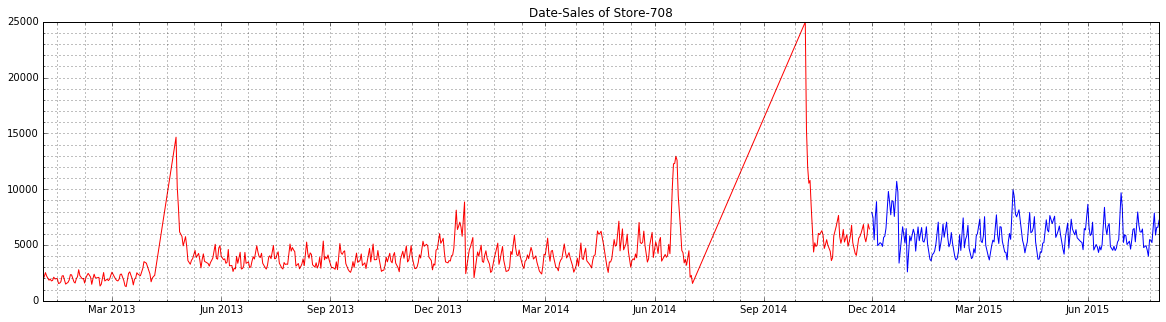

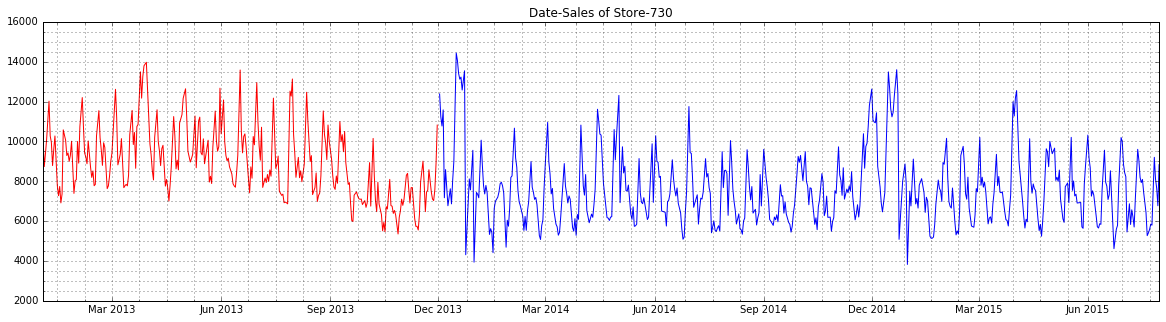

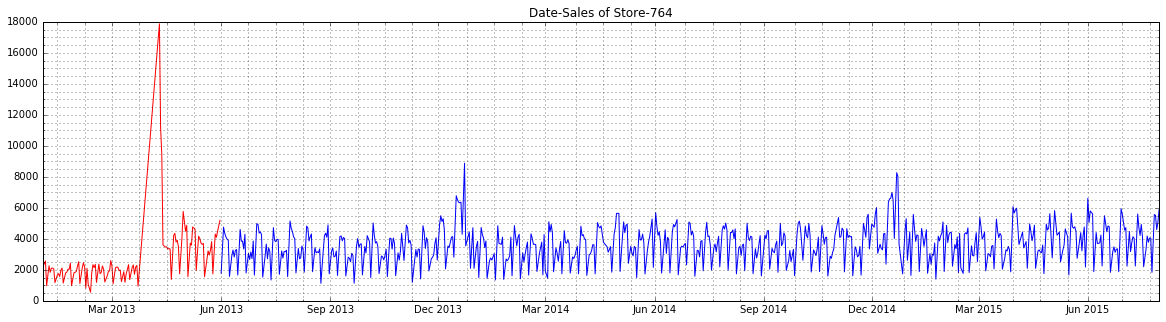

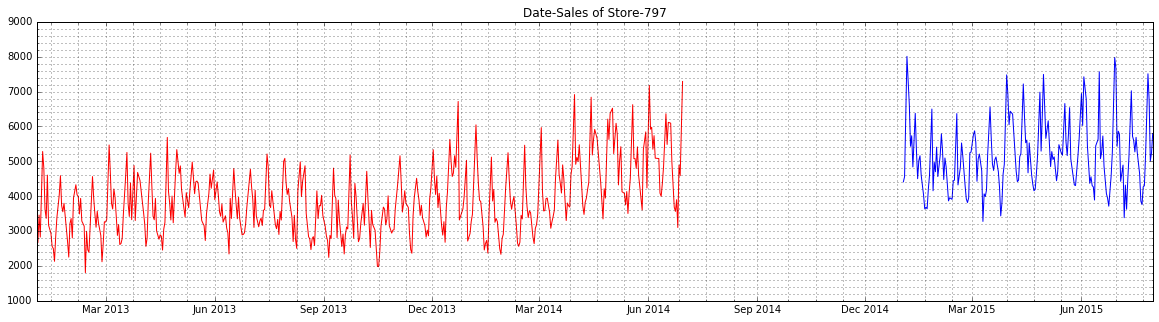

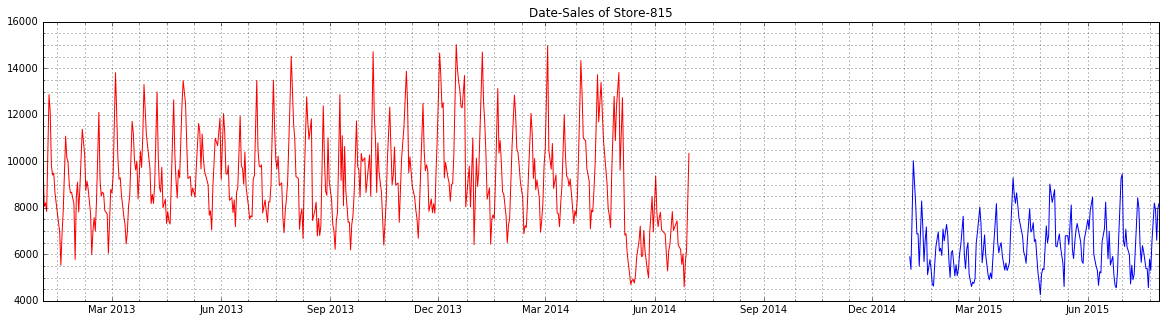

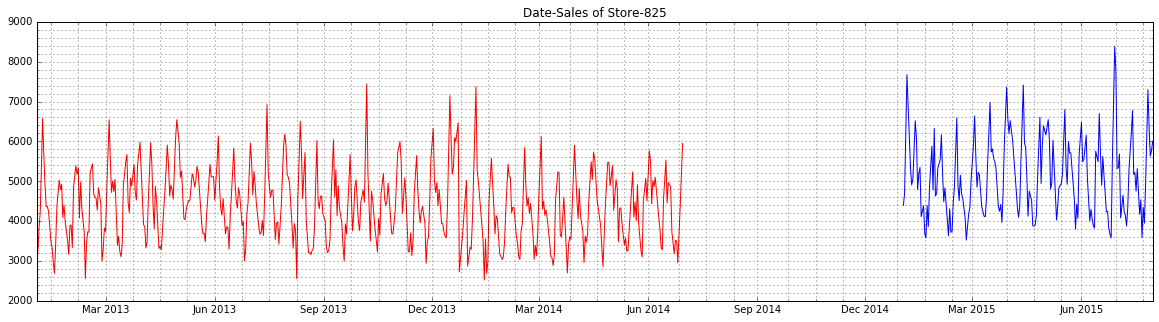

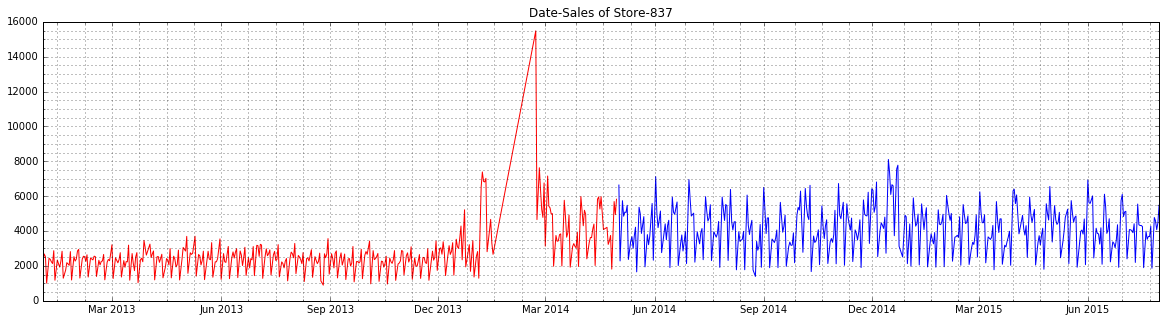

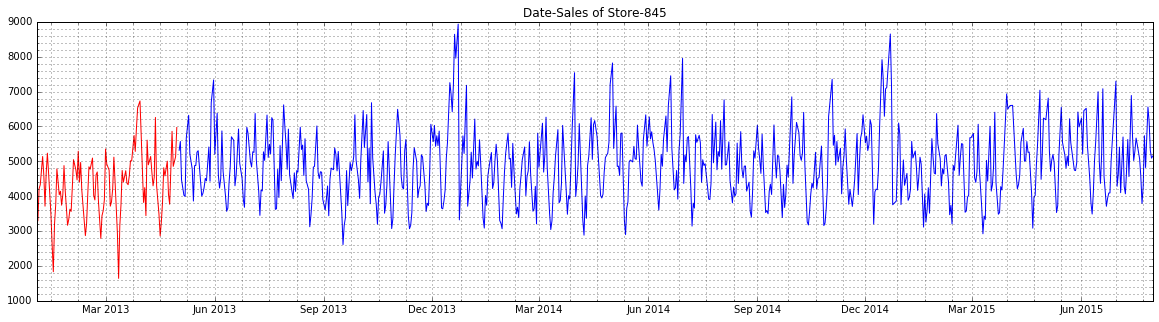

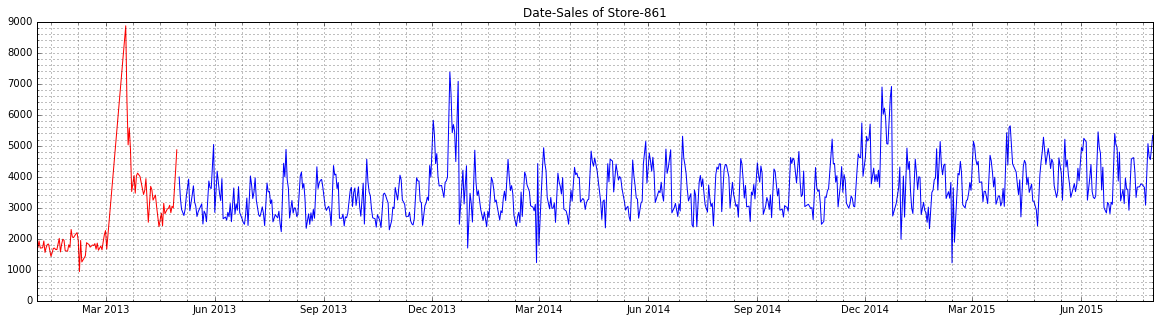

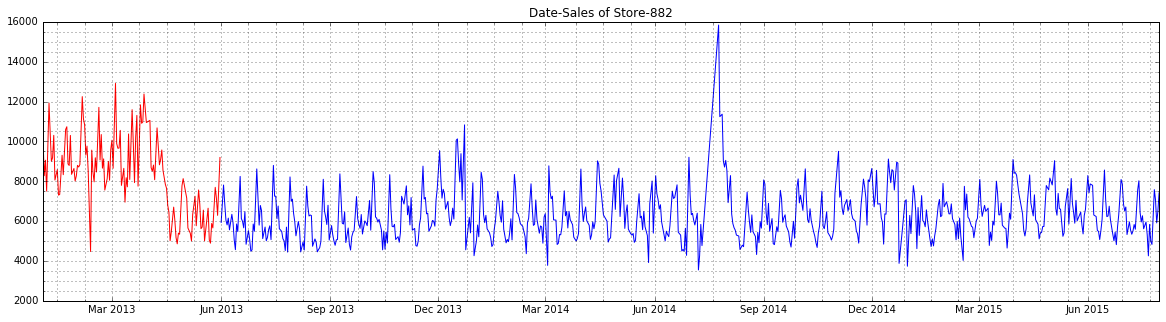

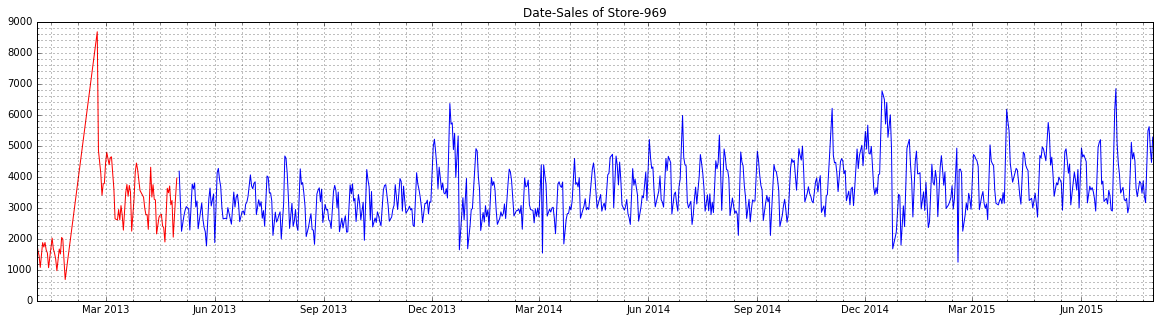

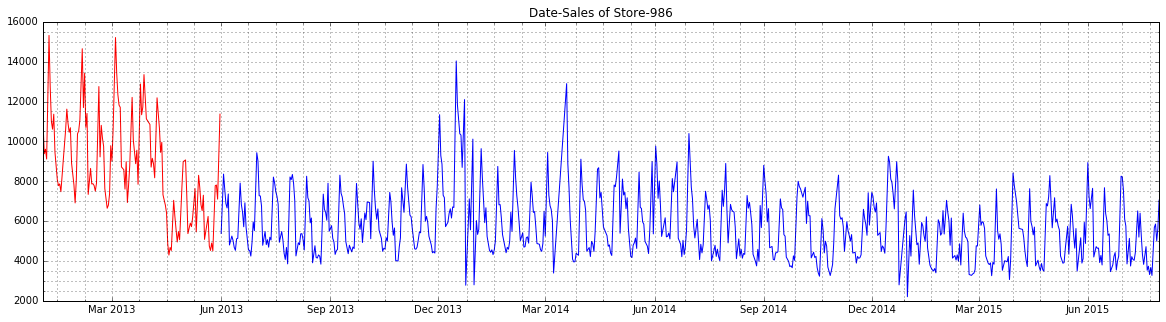

In [26]:
store_dates_to_remove={
        105:'2013-06-01',
        163:'2013-05-01',
        172:'2013-05-01',
        364:'2013-07-01',
        378:'2014-02-01',
        523:'2014-02-01',
        589:'2013-07-01',
        663:'2014-03-01',
        676:'2013-05-01',
        681:'2013-08-01',
        700:'2013-08-01',
        708:'2014-12-01',
        730:'2013-12-01',
        764:'2013-06-01',
        837:'2014-05-01',
        845:'2013-05-01',
        861:'2013-05-01',
        882:'2013-06-01',
        969:'2013-05-01',
        986:'2013-06-01',
        192:'2015-01-01',
        263:'2015-01-01',
        500:'2015-01-01',
        797:'2015-01-01',
        815:'2015-01-01',
        825:'2015-01-01'
}

j=1
    
for key, value in collections.OrderedDict(sorted(store_dates_to_remove.items())).iteritems():
    df.loc[(df['Store']==key)&(df['Date']<pd.to_datetime(value)),'Delete']=True
    stor=key
    
    #Normal sales    

    x1=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1)&(df['Delete']==True),['Date','Sales']])    
    x1.set_index('Date',inplace=True)
    x2=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1)&(df['Delete']!=True),['Date','Sales']])    
    x2.set_index('Date',inplace=True)
    
    plt.rcParams["figure.figsize"] = [20,5]
    plt.plot(x1,'r-')
    plt.plot(x2,'b-')
    plt.minorticks_on()
    plt.grid(True,which='both')
    plt.title('Date-Sales of Store-{}'.format(stor))
    plt.show()
    j+=1



In [27]:
### Delete the data where sales in the first periods is much different from the rest
df=df.loc[df['Delete']!=True]

## Remove outliers with deviation>=3


In [62]:
def mad_based_outlier(points, thresh=3.5):
    diff=np.absolute(points-np.median(points))
    mad=np.median(diff)
    modified_z_score=0.6745*diff/mad
    return modified_z_score>thresh
for i in df['Store'].unique():
    df.loc[((df['Set']==1) & (df['Store']==i)& (df['Open']==1)),'Outlier']=mad_based_outlier(
        df.loc[((df['Set']==1) & (df['Store']==i)& (df['Open']==1))]['Sales'] ,3
    )    
    

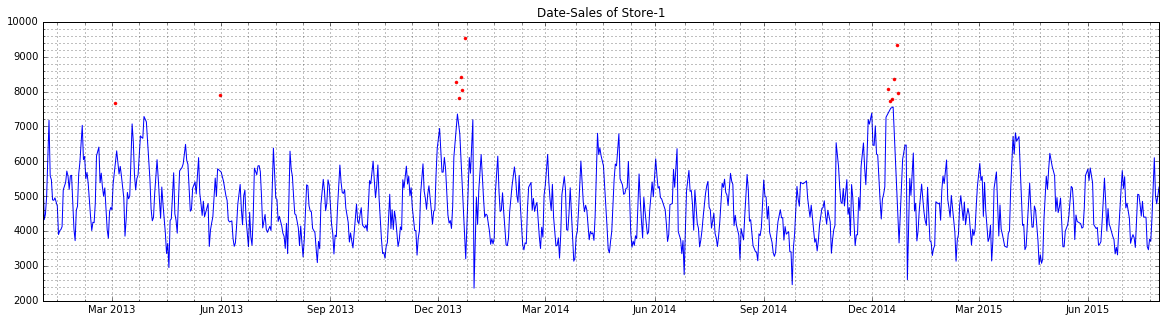

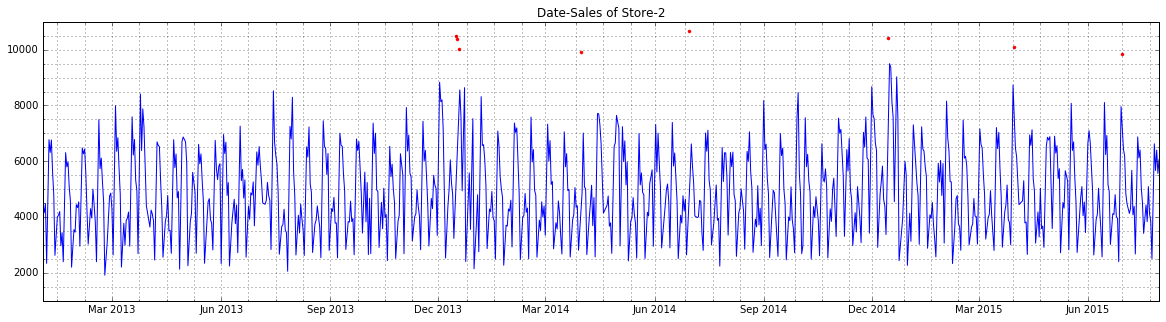

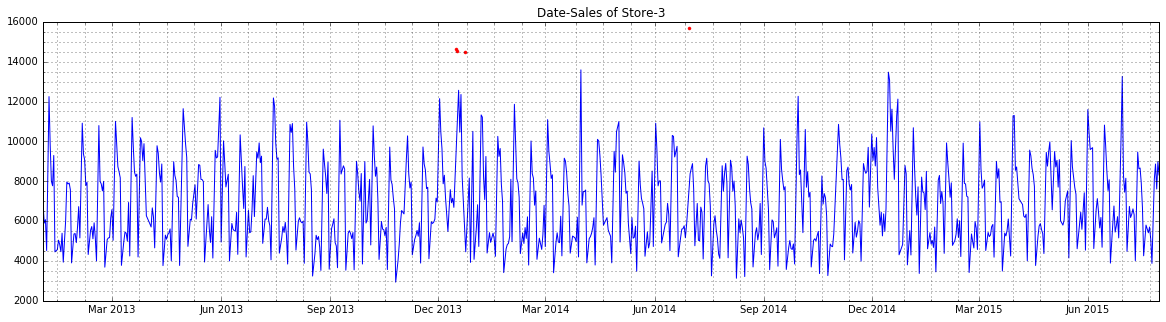

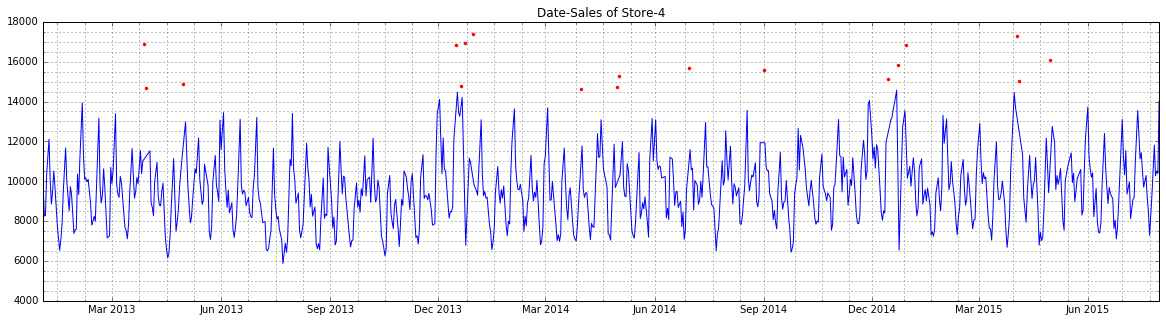

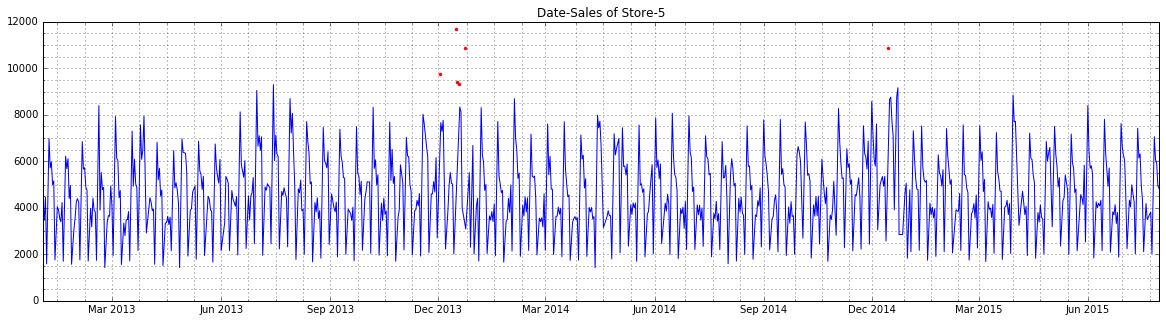

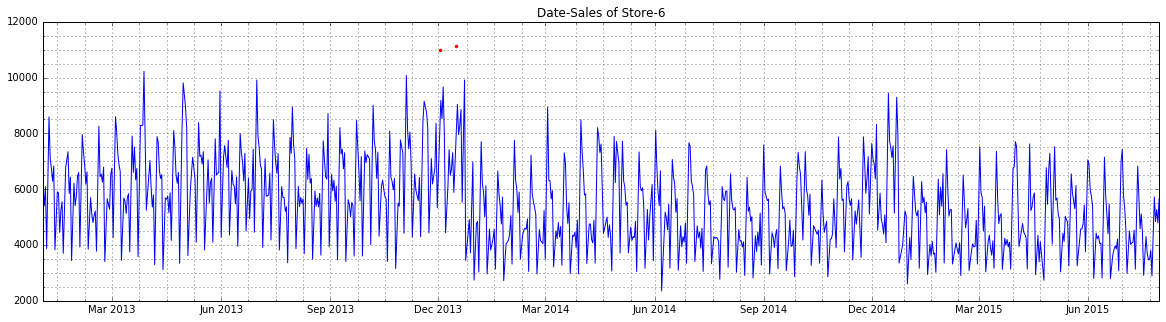

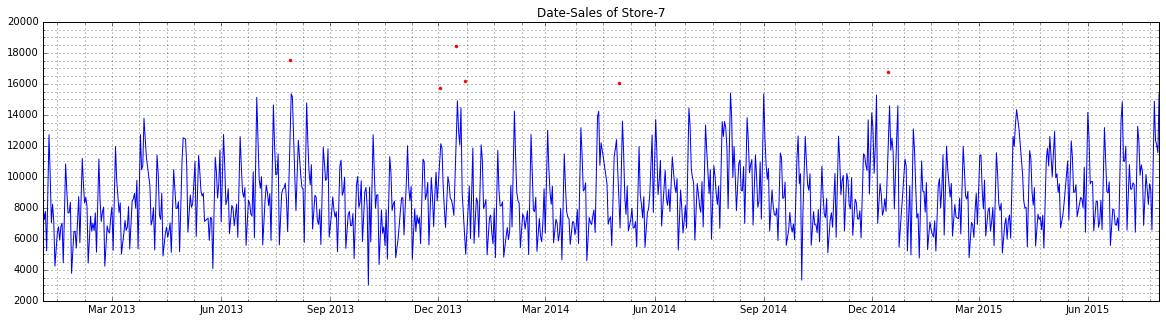

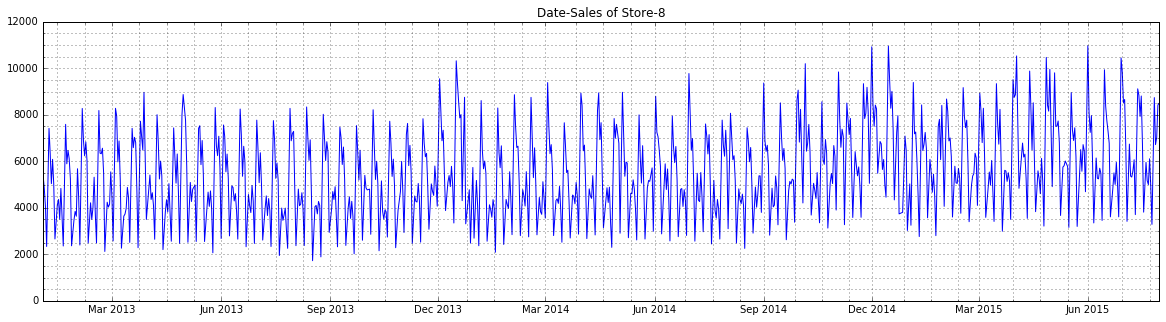

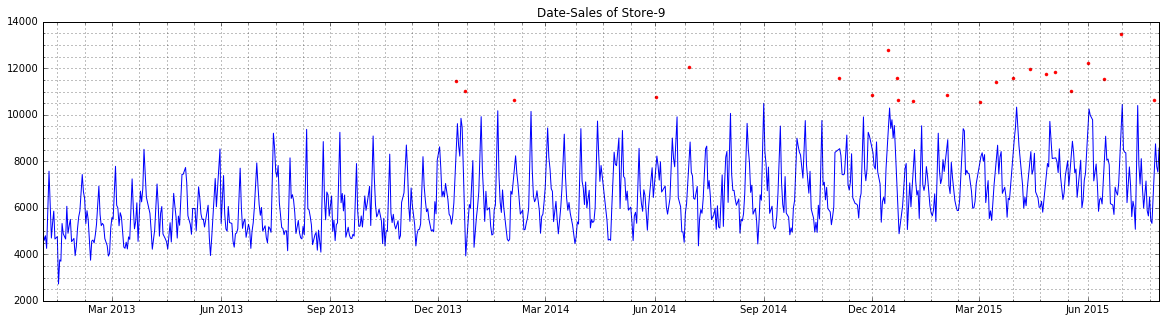

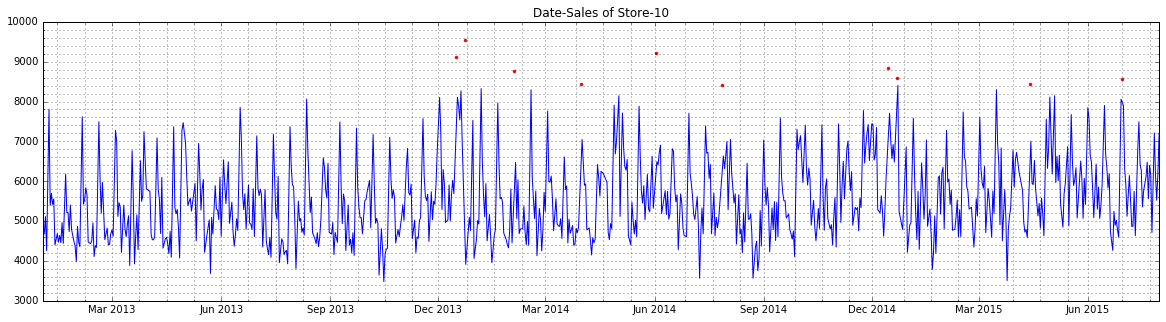

In [66]:
no_stores_to_check=10

for i in range(1,no_stores_to_check+1):
    stor=i
    
    
    x1=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1)&(df['Outlier']!=True),['Date','Sales']])    
    x1.set_index('Date',inplace=True)
    x2=pd.DataFrame(df.loc[(df['Set']==1)&(df['Store']==stor)&(df['Open']==1)&(df['Outlier']==True),['Date','Sales']])    
    x2.set_index('Date',inplace=True)
    
    plt.rcParams["figure.figsize"] = [20,5]
    plt.plot(x1,'-')
    plt.plot(x2,'r.')
    plt.minorticks_on()
    plt.grid(True,which='both')
    plt.title('Date-Sales of Store-{}'.format(stor))
    plt.show()
    j+=1
    

### Split Data in Training and Test for Filling in the outliers

In [87]:
df['CompetitionOpenInt']=df['CompetitionOpenInt'].astype(np.int64)

In [91]:
features_x

['DayOfWeek',
 'DateWeek',
 'StateHoliday',
 'CompetitionOpenInt',
 'Promo',
 'CompetitionDistance',
 'DateDay',
 'DateYear',
 'DateDayOfYear',
 'DateMonth',
 'PromoInterval0',
 'StoreType',
 'Assortment',
 'Open',
 'SchoolHoliday',
 'Store']

In [100]:
feature_temp=['DayOfWeek',
#  'DateWeek',
#  'StateHoliday',
#  'CompetitionOpenInt',
#  'Promo',
#  'CompetitionDistance',
#  'DateDay',
#  'DateYear',
#  'DateDayOfYear',
#  'DateMonth',
#  'PromoInterval0',
#  'StoreType',
#  'Assortment',
#  'Open',
#  'SchoolHoliday',
#  'Store'
             ]
X_train,X_test,y_train,y_test=train_test_split(
    df.loc[((df['Set']==1)&(df['Open']==1)&(df['Outlier']==False) )][feature_temp],
    df.loc[((df['Set']==1)&(df['Open']==1)&(df['Outlier']==False) )]['SalesLog'],
    test_size=0.1,
    random_state=seed
    )

In [75]:
# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [101]:
dtrain=xgb.DMatrix(X_train,y_train)

TypeError: a float is required

In [73]:
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
num_round=20000
evallist=[(dtrain,'train'),(dtest,'test')]
param={
    'bst:max_depth':12,
    'bst:eta':0.01,
    'sbusample':0.8,
    'colsmaple_bytree':0.7,
    'silent':1,
    'objective':'reg:linear',
    'nthread':6,
    'seed':seed
}

plst=param.items()
bst=xgb.train(plst,dtrain,num_round,evallist,feval=rmspe_xg,verbose_eval=250,early_stopping_rounds=250)

TypeError: can not intialize DMatrix from DataFrame